### Init

In [1]:
using Pkg
Pkg.activate("../one_flav_env")

using QuadGK
using DifferentialEquations
using Interpolations
using Roots
using Plots
import SpecialFunctions: besselk
import LinearAlgebra: dot
import PhysicalConstants.CODATA2018: G, FineStructureConstant
using NaturallyUnitful

const αEM = float(FineStructureConstant)
const Grav = ustrip(uconvert(u"GeV^-2", natural(float(G))))
const gstar = 100
const T0 = 2.348e-13 # GeV
const sW2 = .23121 # sine of weak-mixing angle squared
const cW2 = 1 - sW2
const mZ = 91.1876 # GeV
const Mstar = 90*(2.131e-42)^2/(T0^3*8*π*Grav)
const lifetime_conv = ustrip(unnatural(u"s", 1*u"GeV^-1"))

function arctanh(x)
    .5*(log(1+x) - log(1-x))
end

function bkf(u, x)
    t1 = sqrt(x/π)
    t2 = -(57+4*u)/(16*sqrt(x*π))
    t3 = (4185+24*u*(17+2*u)) / (512 * sqrt(π*x^3))
    t4 = -5*(24135+2724*u+432*u^2+64*u^3) / (8192*sqrt(π*x^5))
    return t1+t2+t3+t4
end

function bk2_ratio(x, δ)
    if x < 1e-2
        return δ^2*(1-(1-δ^2)*x^2/4)
    elseif x < 1e2/δ
        return besselk(2,x)/besselk(2,δ*x)
    else
        return exp(-(1-δ)*x)*(sqrt(δ)-15*(1-δ)/(8*x*sqrt(δ)))
    end
end

"""
    hubble(T)

Gives the Hubble constant H in GeV

T : Temperature [GeV]
"""
function hubble(T)
    T^2 * sqrt(4*π^3*Grav*gstar/45)
end

struct LFDM{T <: Real}
    λ::T
    mφ::T
    gφ::Int
    mχ::T
    gχ::Int
    h::T
end
;

### Cross-sections

In [2]:
function Y_eq(x, g)
    g/(2*π^2) * x^2 * besselk(2,x)
end

function Y_eq_ratio(x, model::LFDM)
    (model.gφ/model.gχ)*(model.mφ/model.mχ)^2*bk2_ratio(x, model.mχ/model.mφ)
end

function Γ4(model)
    model.λ^2*model.mφ*(1-model.mχ^2/model.mφ^2)^2 / (16*π)
end

function σ3(α)
    η = sqrt(1-4/α)
    return π*αEM^2*η^3 / (3*α)
end

function σ3Z(α, model::LFDM)
    η = sqrt(1-4/α)
    z = mZ / model.mφ
    inside = 5*α^2-12*α*cW2*(α-2*sW2*(α-z^2)) + 8*cW2^2*(α-2*sW2*(α-z^2))^2
    pref = αEM^2*π/(96*sW2^2*cW2^2)
    return pref*inside*η^3 / (α*(α-z^2)^2)
end

function σ8(α)
    β = 4/α
    η = sqrt(1-4/α)
    return 2*π*αEM^2/α * (η*(2+β)-β*(1+η^2)*arctanh(η))
end

σ38(α) = σ3(α) + σ8(α)
σ3Z8(α) = σ3Z(α) + σ8(α)

function C22(σ, x, model::LFDM)
    if x < 1e-2
        return model.mφ*σ(1e10)*1e10/(2*model.h*model.gφ^2)
    elseif x < 1e2
        pref = model.mφ / (2*x*model.h*model.gφ^2*besselk(2,x)^2)
        I = quadgk(α -> α^(3/2)*σ(α)*besselk(1,x*sqrt(α)), 4, Inf)[1]
        return pref*I
    else
        pref = model.mφ / (x^2*model.h*model.gφ^2)
        I = quadgk(u -> exp(-u)*(u/x+2)^4*σ((u/x+2)^2)*bkf(u, x), 0, Inf)[1]
        return pref*I
    end
end

function C12(Γ, x, model::LFDM)
    if x < 1e-2
        return x^2*Γ(model)/(2*model.h)
    elseif x < 1e2
        return x*Γ(model)*besselk(1,x)/(model.h*besselk(2,x))
    else
        return x*Γ(model)/model.h * (1-3/(2*x))
    end
end
;

### Differential Equations

In [3]:
function diffeq(du, u, p, x)
    yeq_φ = Y_eq(x, p.gφ)
    yeq_rat = Y_eq_ratio(x, p)

    decay = C12(Γ4, x, p)*(exp(-u[1]) - u[2]*yeq_rat)

    du[1] = exp(u[1])*(C22(σ38, x, p)*(exp(-2*u[1])-yeq_φ^2) + decay)
    du[2] = decay
end

function diffeq_1Z(du, u, p, x)
    yeq_φ = Y_eq(x, p.gφ)
    yeq_rat = Y_eq_ratio(x, p)

    decay = C12(Γ4, x, p)*(exp(-u[1]) - u[2]*yeq_rat)

    du[1] = exp(u[1])*(C22(σ3Z8, x, p)*(exp(-2*u[1])-yeq_φ^2) + decay)
    du[2] = decay
end

function f_φ(y, p, x)
    yeq_φ = Y_eq(x, p.gφ)
    exp(y)*C22(σ38, x, p)*(exp(-2*y)-yeq_φ^2)
end

function f_χ(y, p, x)
    yeq_χ = Y_eq(x*p.mχ/p.mφ, p.gχ)
    yeq_rat = Y_eq_ratio(x, p)
    return yeq_rat*C12(Γ4,x,p)*(yeq_χ-y)
end
;

### Relationships given Ωh^2 = .12

In [4]:
function find_yφf(mphi; gphi=2, x0=1e-4, xf=1e8)
    M = LFDM(0.0, mphi, gphi, 0.0, 0, hubble(mphi))

    z0 = -log(Y_eq(x0, M.gφ))

    prob = ODEProblem(f_φ, z0, (x0, xf), M)
    sol = solve(prob, Rodas5P())

    return exp(-sol(xf))
end

function find_yχf(λ, mφ, mχ; gφ=2, gχ=2)
    mm = LFDM(λ, mφ, gφ, mχ, gχ, hubble(mφ))

    return 3*gφ*Γ4(mm) / (4*π*mm.h)
end

function find_λ(mφ, mχ)
    yφfo = find_yφf(mφ)
    yχfi = find_yχf(1.0, mφ, mχ)

    return sqrt( (Mstar/mχ - yφfo) / yχfi )
end

function Ωh2(y, m)
    y*m*T0^3*8*π*Grav/(90*(2.131e-42)^2)
end

const aa = 3*2/(64*π^2)*(1e3)^2/hubble(1e3)
const bb = find_yφf(1e3)/1e3

function ff(μφ, μχ, ατ)
    μφ^2 / (1 + ατ^2 * μφ^3) - μχ
end

function find_mφ_τ(τφ, mχ)
    τ = τφ/lifetime_conv
    μ1 = 16*π*aa/(Mstar*τ)
    α = μ1*sqrt(bb/Mstar)

    mφ_peak = μ1*(2 / α^2)^(1/3)
    mχ_peak = ff(mφ_peak/μ1, 0, α)*μ1
    λ_peak = find_λ(mφ_peak, mχ_peak)

    mφ1, mφ2 = find_zeros(x -> ff(x, mχ/μ1, α), 1e-3, 1e3) .* μ1

    vmφ = [mφ1, mφ2, mφ_peak]
    λ1 = find_λ(mφ1, mχ)
    λ2 = find_λ(mφ2, mχ)

    λs = [λ1, λ2, λ_peak]
    vmχ = [mχ, mχ, mχ_peak]

    return λs, vmφ, vmχ
end
;

### Test parameters

In [5]:
a = 1e4
mphi = 1e4
gphi = 2
mchi = 50.0
gchi = 4

λ = 1e-11
M = LFDM(λ, mphi, gphi, mchi, gchi, hubble(mphi))
;

In [6]:
x0 = 1e-4
xf = 1e6
z0 = [-log(Y_eq(x0, M.gφ)), 0.0]
y0 = 0.0
xspan = (x0, xf)

prob = ODEProblem(diffeq, z0, xspan, M)
sol = solve(prob, Rodas5P())

# prob2 = ODEProblem(f_χ, y0, xspan, M)
# sol2 = solve(prob2, AutoTsit5(Rodas5P()))

# prob3 = ODEProblem(f_φ, z0[1], xspan, M)
# sol3 = solve(prob3, Rodas5P())

prob4 = ODEProblem(diffeq_1Z, z0, xspan, M)
sol4 = solve(prob, Rodas5P())

xrange = 10 .^range(log10(1e-4), log10(xf), 10000)
yeqs = Y_eq.(xrange, M.gφ)

Yφs = zero(xrange)
Yχs = zero(xrange)
Yχ_Z = zero(xrange)
Yφ_Z = zero(xrange)
for (i,x) in enumerate(xrange)
    Yφs[i] = exp(-sol(x)[1])
    Yχs[i] = sol(x)[2]
    # Yχ_est[i] = sol2(x)
    # Yφ_est[i] = exp(-sol3(x))
    Yφ_Z[i] = exp(-sol4(x)[1])
    Yχ_Z[i] = sol(x)[2]
end
;

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 6845 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/rz1WP/src/utils.jl:106


┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 6845 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/rz1WP/src/utils.jl:106


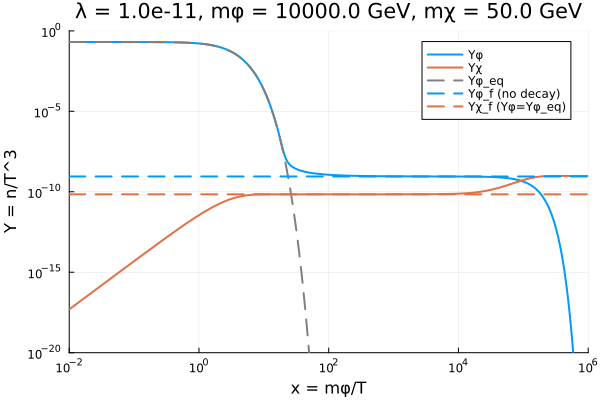

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 6845 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/rz1WP/src/utils.jl:106


In [9]:
plot(xrange, Yφs, lw=2., label="Yφ", c=1, xaxis=:log10, yaxis=:log10)
plot!(xrange, Yχs, lw=2., label="Yχ", c=2, xaxis=:log10, yaxis=:log10)
# plot!(xrange, Yχ_est, lw=2., label="Yχ (Yφ=Yφ_eq)", linestyle=:dashdot, c=2, xaxis=:log10, yaxis=:log10)
# plot!(xrange, Yφ_est, lw=2., label="Yφ (no decay)", linestyle=:dashdot, c=2, xaxis=:log10, yaxis=:log10)
plot!(xrange, yeqs, label="Yφ_eq", lw=2., linestyle=:dash, c="grey", xaxis=:log10, yaxis=:log10)
plot!(xrange, find_yφf(M.mφ)*ones(typeof(xrange[1]), length(xrange)), label="Yφ_f (no decay)", 
        lw=2., linestyle=:dash, c=1, xaxis=:log10, yaxis=:log10)
plot!(xrange, find_yχf(M.λ, M.mφ, M.mχ)*ones(typeof(xrange[1]), length(xrange)), label="Yχ_f (Yφ=Yφ_eq)", 
        lw=2., linestyle=:dash, c=2, xaxis=:log10, yaxis=:log10)
# plot!(xrange, Yφ_Z, lw=2., label="Yφ with Z in 3", c=1, xaxis=:log10, yaxis=:log10)
# plot!(xrange, Yχ_Z, lw=2., label="Yχ with Z in 3", c=1, xaxis=:log10, yaxis=:log10)
xlims!(1e-2, 1e6)
ylims!(1e-20, 1)
title!("λ = $(M.λ), mφ = $(M.mφ) GeV, mχ = $(M.mχ) GeV")
xlabel!("x = mφ/T")
ylabel!("Y = n/T^3")
# savefig("relic_10_400_1.pdf")

### Testing two different mφ along the same τφ and mχ

In [39]:
λs_test, mφs_test, mχs_test = find_mφ_τ(1e-3, 1e2)
Ms = LFDM.(λs_test[1:2], mφs_test[1:2], 2, mχs_test[1:2], 2, hubble.(mφs_test[1:2]))

2-element Vector{LFDM{Float64}}:
 LFDM{Float64}(1.0488600421569756e-11, 354.6573309248682, 2, 100.0, 2, 1.7103691249993056e-13)
 LFDM{Float64}(2.4556487333634936e-11, 18929.52751071284, 2, 100.0, 2, 4.872496247942056e-10)

In [40]:
x0 = 1e-4
xf = 1e6
z0 = [-log(Y_eq(x0, 2)), 0.0]
y0 = 0.0
xspan = (x0, xf)

xrange = 10 .^range(log10(x0), log10(xf), 10000)
yeqs = Y_eq.(xrange, 2)

Yφs = zeros(typeof(x0), (length(Ms), length(xrange)))
Yχs = zeros(typeof(x0), (length(Ms), length(xrange)))

for (i, mm) in enumerate(Ms)
    prob = ODEProblem(diffeq, z0, xspan, mm)
    sol = solve(prob, Rodas5P())

    for (j,x) in enumerate(xrange)
        Yφs[i,j] = exp(-sol(x)[1])
        Yχs[i,j] = sol(x)[2]
    end
end

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/aradick/.julia/packages/SciMLBase/YUCZN/src/integrator_interface.jl:606


┌ Warning: Invalid negative or zero value 0.0 found at series index 6845 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/QWCV6/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 9788 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/QWCV6/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/QWCV6/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/QWCV6/src/utils.jl:106


┌ Warning: Invalid negative or zero value 0.0 found at series index 6845 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/QWCV6/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 9788 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/QWCV6/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/QWCV6/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/QWCV6/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 6845 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/QWCV6/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 9788 for log10 based yscale
└ @ Plots /home/aradick/.julia/packages/Plots/QWCV6/src/utils.jl:106
┌ Warning: Inval

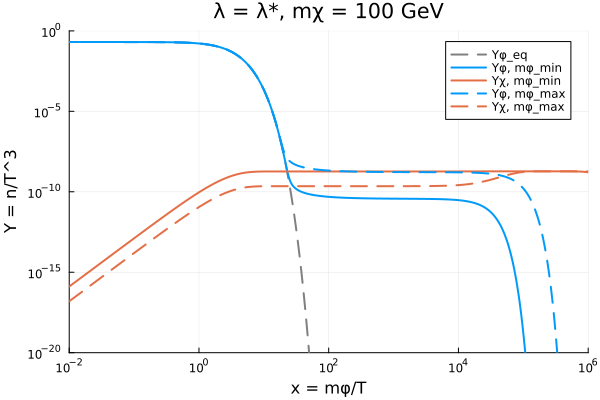

In [43]:
LS = [:solid, :dash, :dashdot]
Labelφ = ["Yφ, mφ_min", "Yφ, mφ_max"]
Labelχ = ["Yχ, mφ_min", "Yχ, mφ_max"]

plot(xrange, yeqs, label="Yφ_eq", lw=2., linestyle=:dash, c="grey", xaxis=:log10, yaxis=:log10)
for i in range(1,length(Ms))
    plot!(xrange, Yφs[i,:], lw=2., label=Labelφ[i], c=1, linestyle=LS[i], xaxis=:log10, yaxis=:log10)
    plot!(xrange, Yχs[i,:], lw=2., label=Labelχ[i], c=2, linestyle=LS[i], xaxis=:log10, yaxis=:log10)
end
xlims!(1e-2, 1e6)
ylims!(1e-20, 1)
title!("λ = λ*, mχ = 100 GeV")
xlabel!("x = mφ/T")
ylabel!("Y = n/T^3")
# savefig("two_different_mphi.pdf")